# Problem description

**Context**
---
Churn prediction means detecting which customers are likely to cancel a subscription to a service based on how they use the service. It is a critical prediction for many businesses because acquiring new clients often costs more than retaining existing ones.

**Objective**
---

To build a model which would predict this user have exited or not

**Features**
---
  
 0.   RowNumber
 1.   CustomerId
 2.   Surname
 3.   CreditScore
 4.   Geography
 5.   Gender
 6.   Age
 7.   Tenure
 8.   Balance
 9.   NumOfProducts
 10.  HasCrCard
 11.  IsActiveMember
 12.  EstimatedSalary


**Label**
---

 1.  Exited  


# **Downloading dataset**

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir dataset

In [ ]:
%cd /content/dataset

/content/dataset


In [ ]:
!kaggle datasets download -d "shrutimechlearn/churn-modelling"

  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 57.6MB/s]


In [ ]:
!unzip "/content/dataset/churn-modelling.zip"

Archive:  /content/dataset/churn-modelling.zip
  inflating: Churn_Modelling.csv     


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# **Reading dataset**

In [2]:
df = pd.read_csv('Churn_Modelling.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


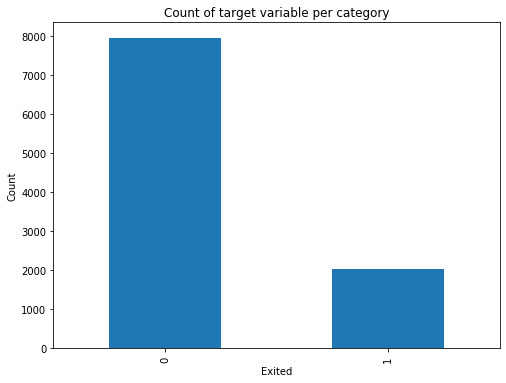

In [11]:
df['Exited'].value_counts().plot(kind='bar',figsize=(8,6))
plt.xlabel('Exited')
plt.ylabel('Count')
plt.title('Count of target variable per category')
plt.show()

In [14]:
print(100 * df['Exited'].value_counts()/len(df))


0    79.63
1    20.37
Name: Exited, dtype: float64


* it is pretty clear that the data is imbalanced. Around 79% of the records are for the people who didn't exit and in just 20% of the records the customer churned.

In [25]:
# Let's check for missing values
np.round(df.isnull().mean(),4)

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

* remove the features that are not useful

In [27]:
data=df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [28]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [29]:
#Checking for numerical features
numerical_features=[feature for feature in data.columns if data[feature].dtype!='O']
print('Number of numerical features: ',len(numerical_features))
print(data[numerical_features].head())

Number of numerical features:  9
   CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  
0               1        101348.88       1  
1               1        112542.58       0  
2               0        113931.57       1  
3               0         93826.63       0  
4               1         79084.10       0  


In [30]:
# Checking for discrete numerical features
discrete_numerical_features=[feature for feature in numerical_features if len(data[feature].unique())<20]
print('Number of numerical features: ',len(discrete_numerical_features))
print(data[discrete_numerical_features].head())

Number of numerical features:  5
   Tenure  NumOfProducts  HasCrCard  IsActiveMember  Exited
0       2              1          1               1       1
1       1              1          0               1       0
2       8              3          1               0       1
3       1              2          0               0       0
4       2              1          1               1       0


In [31]:
# Checking for continuous features
continuous_numerical_features=[feature for feature in numerical_features if len(data[feature].unique())>20]
print('Number of continuous features: ',len(continuous_numerical_features))
print(data[continuous_numerical_features].head())

Number of continuous features:  4
   CreditScore  Age    Balance  EstimatedSalary
0          619   42       0.00        101348.88
1          608   41   83807.86        112542.58
2          502   42  159660.80        113931.57
3          699   39       0.00         93826.63
4          850   43  125510.82         79084.10


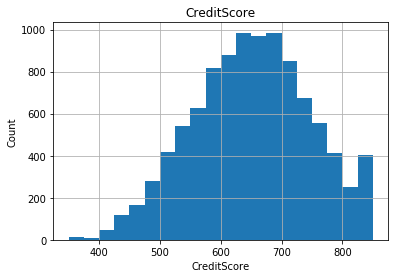

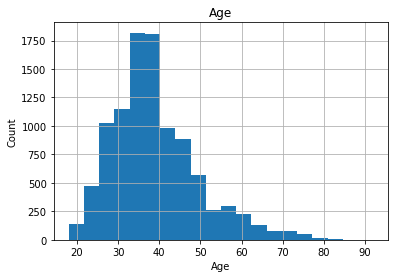

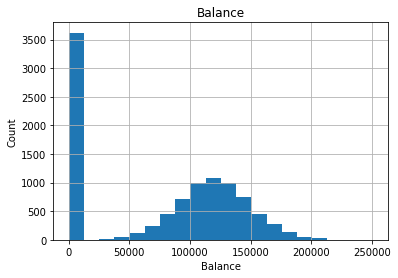

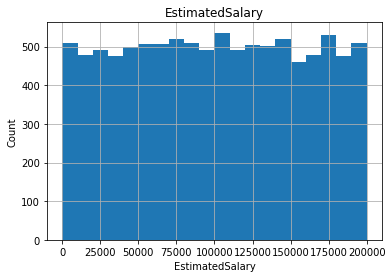

In [32]:
# Let's understand the distribution of the continuous variables by plotting the histograms

for feature in continuous_numerical_features:
    df=data.copy()
    df[feature].hist(bins=20)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

* the credit score data and Balance data have normal distribution whereas the age data is left skewed and Estimated salary is uniformly distributed.

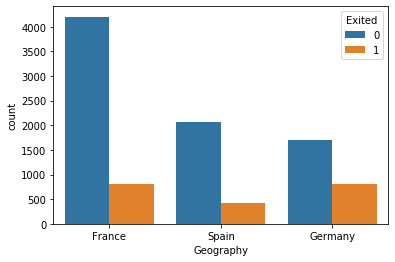

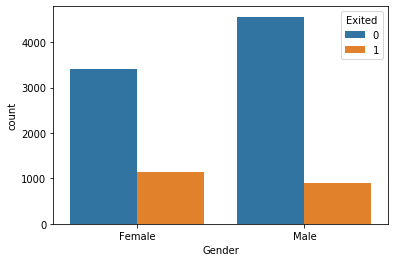

In [33]:

cat_data=data[['Geography','Gender']]
for i ,predictor in enumerate(cat_data):
    plt.figure(i)
    sns.countplot(data=data, x=predictor,hue='Exited')

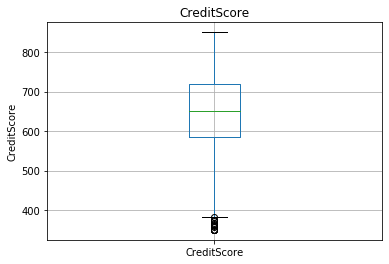

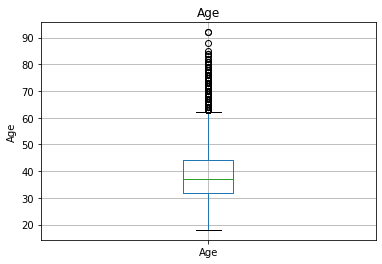

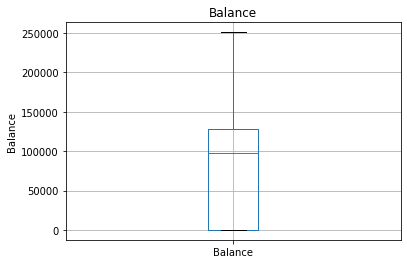

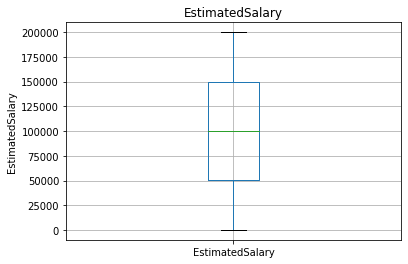

In [34]:
# We will now check for outliers

for feature in continuous_numerical_features:
    df=data.copy()
    if 0 in df[feature].unique():
        pass
    df.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

In [35]:
# Removing the outliers for Age 

q1_age =data['Age'].quantile(0.25)
q3_age=data['Age'].quantile(0.75)
iqr_age=q3_age-q1_age
lower=q1_age-(1.5 * iqr_age)
upper=q3_age+(1.5 * iqr_age)
data=data[data['Age']>lower]
data=data[data['Age']<upper]

In [36]:
# Removing the outliers for credit score

q1_credit=data['CreditScore'].quantile(0.25)
q3_credit=data['CreditScore'].quantile(0.75)
iqr_credit=q3_credit-q1_credit
lower=q1_credit-(1.5 * iqr_credit)
upper=q3_credit+(1.5 * iqr_credit)
data=data[data['CreditScore']>lower]
data=data[data['CreditScore']<upper]

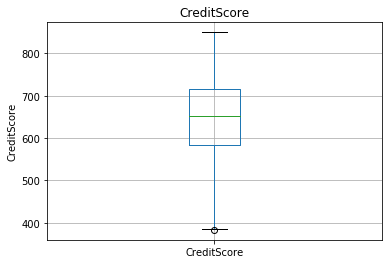

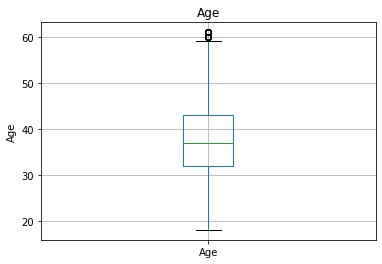

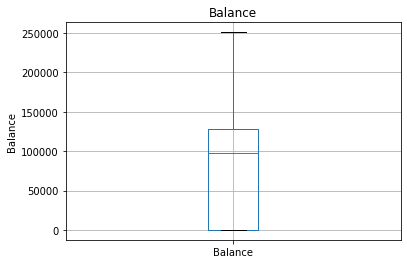

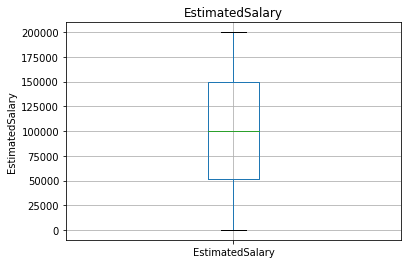

In [38]:
for feature in continuous_numerical_features:
    df=data.copy()
    if 0 in df[feature].unique():
        pass
    df.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

In [37]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
